# Deeptech M&A Taxonomy: LLM Embedding and Clustering

## Phase 2: Text Feature Engineering and Vector Generation

This notebook takes the cleaned M\&A data and uses an LLM API to transform the unstructured text rationale (`comments`, `target_name`, `buyer_name`) into numerical vectors (embeddings). These vectors will then be used for unsupervised clustering to discover deeptech sectors.

In [1]:
from pathlib import Path
import sys
import time
import warnings

# Suppress warnings from third-party libraries
warnings.filterwarnings("ignore", category=SyntaxWarning)
warnings.filterwarnings("ignore", message="IProgress not found")

from dotenv import load_dotenv
import hdbscan
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

sys.path.append(str(Path.cwd() / "src"))
import llm_tools

✓ Using OpenAI API for embeddings


In [2]:
# Load environment variables from .env file
load_dotenv()
print("Environment variables loaded.")

# Configuration
CLEANED_DATA_PATH = Path("../../data/processed/1.1_cleaned_data.csv")
EMBEDDINGS_DATA_PATH = Path("../../data/processed/1.2_embeddings_and_features.parquet")

Environment variables loaded.


### 2.1: Load data and create text feature

In [3]:
df_cleaned = pl.read_csv(CLEANED_DATA_PATH)

# Use the utility function to concatenate the text fields into a single column
df_features = llm_tools.create_text_feature(df_cleaned)

print(f"Created 'embedding text' feature for {len(df_features):,} transactions.")
print("Sample text feature:")
print(df_features.select("embedding_text").head(1).item())

Created 'embedding text' feature for 38,655 transactions.
Sample text feature:
Target: Warner Media, LLC. Buyer: Warner Bros. Discovery, Inc. (NasdaqGS:WBD). Rationale: Discovery, Inc. (NasdaqGS:DISC.A) entered into a definitive agreement to acquire Warner Media, LLC from AT&T Inc. (NYSE:T) for $60.6 billion on May 17, 2021. The transaction is structured as a reverse morris trust transaction. As per the estimated preliminary purchase calculation, Discovery, Inc. will issue 1,701 Million shares to the shareholders of AT&T Inc. (NYSE:T). Discovery will also assume Long-term debt of $43.33 Billion. Under the terms of the transaction, AT&T Inc. will transfer the business, operations and activities that constitute the Warner Media segment, subject to certain exceptions to Magallanes, Inc. (Spinco, a wholly owned subsidiary of AT&T Inc). Xandr and Crunchyroll are not included in the transaction. In connection with the separation, Spinco will remain obligated for certain debt of the existing 

### Step 2.2: Generate embeddings (API call)
**DANGER ZONE:** This operation interacts with the external LLM API and costs resources. It includes retry logic (`llm_tools.py`) to minimize failures due to rate limits.


In [4]:
# Extract the list of text features to send to the API
texts_to_embed = df_features.select("embedding_text").to_series().to_list()

# Progress files to track completed embeddings
progress_file = Path("../../data/processed/embeddings_progress.csv")
embeddings_file = Path("../../data/processed/embeddings_vectors.npy")

# Check if we have existing progress
if progress_file.exists() and embeddings_file.exists():
    print(f"Found existing progress files")
    df_progress = pl.read_csv(progress_file)
    completed_count = len(df_progress)
    
    # Load embeddings from numpy file
    embeddings_array = np.load(embeddings_file)
    embeddings_list = embeddings_array.tolist()
    print(f"Resuming from {completed_count:,} completed embeddings")
else:
    completed_count = 0
    embeddings_list = []
    print("Starting fresh - no progress files found")

print(f"\nTotal documents: {len(texts_to_embed):,}")
print(f"Remaining: {len(texts_to_embed) - completed_count:,}\n")

# Process in batches for efficiency
batch_size = 100
remaining_texts = texts_to_embed[completed_count:]

for batch_start in range(0, len(remaining_texts), batch_size):
    batch_end = min(batch_start + batch_size, len(remaining_texts))
    batch_texts = remaining_texts[batch_start:batch_end]
    
    # Generate embeddings for this batch
    print(f"\nProcessing batch: {completed_count + batch_start} to {completed_count + batch_end}...")
    batch_embeddings = llm_tools.generate_embeddings(batch_texts)
    
    # Add to our list
    embeddings_list.extend(batch_embeddings)
    
    # Save progress after each batch
    np.save(embeddings_file, np.array(embeddings_list))
    df_temp = df_features.head(len(embeddings_list))
    df_temp.with_row_index("row_idx").write_csv(progress_file)
    
    print(f"✓ Batch saved: {len(embeddings_list):,}/{len(texts_to_embed):,} total embeddings")

print(f"\n✓ Embedding generation complete. Generated {len(embeddings_list):,} vectors.")
if embeddings_list:
    vector_dimension = len(embeddings_list[0])
    print(f"Vector Dimension: {vector_dimension}")
else:
    vector_dimension = 0

# Convert the list of embeddings (list of lists) into a Polars Series
embeddings_series = pl.Series(name="embedding_vector", values=embeddings_list)

# Attach the new vector column to the main DataFrame
df_features = df_features.with_columns(embeddings_series)

print("✓ Embeddings attached to DataFrame")

Found existing progress files
Resuming from 38,655 completed embeddings

Total documents: 38,655
Remaining: 0


✓ Embedding generation complete. Generated 38,655 vectors.
Vector Dimension: 1536
Resuming from 38,655 completed embeddings

Total documents: 38,655
Remaining: 0


✓ Embedding generation complete. Generated 38,655 vectors.
Vector Dimension: 1536
✓ Embeddings attached to DataFrame
✓ Embeddings attached to DataFrame


### Step 2.3: prepare features for clustering (UMAP/HDBSCAN)

In [5]:
# --- Clustering Setup ---

# Filter out transactions that failed the embedding process
embeddings_matrix = np.array(embeddings_list)
row_norms = np.linalg.norm(embeddings_matrix, axis=1)  # Calculate the L2 norm (magnitude) of each vector
valid_indices = np.where(row_norms > 1e-6)[0] 

# Apply filtering to the DataFrame
df_valid_features = df_features.filter(pl.Series(range(len(df_features))).is_in(valid_indices))

print(f"Original records: {len(df_features):,}")
print(f"Valid records for clustering: {len(df_valid_features):,}")
print(f"Records dropped: {len(df_features) - len(df_valid_features):,}")

# Extract the valid embeddings matrix X, scale and standardize
X = np.array(df_valid_features.get_column("embedding_vector").to_list())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nMatrix X_scaled for Clustering (Shape: {X_scaled.shape}) is ready.")


Original records: 38,655
Valid records for clustering: 38,655
Records dropped: 0

Matrix X_scaled for Clustering (Shape: (38655, 1536)) is ready.

Matrix X_scaled for Clustering (Shape: (38655, 1536)) is ready.


### 2.4: apply UMAP and HDBSCAN

In [10]:
if X_scaled.shape[0] > 10:
    print("Starting Dimensionality Reduction (UMAP)...")
    
    # --- UMAP: Reduce dimension for faster clustering and visualization ---
    
    # Aim for a moderate reduction (e.g., 50 dimensions) to retain semantic fidelity
    umap_reducer = umap.UMAP(
        n_components=50, 
        n_neighbors=15, 
        min_dist=0.1, 
        random_state=42, 
        metric="cosine"  # Use cosine similarity, which is standard for embeddings
    )
    
    X_umap = umap_reducer.fit_transform(X_scaled)
    
    print(f"✓ UMAP reduction complete. Shape: {X_umap.shape}")
    
    # --- HDBSCAN: Perform density-based clustering ---
    
    # We choose conservative parameters suitable for discovering meaningful sectors.
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=100,      # Requires at least 30 deals for a sector to be recognized
        min_samples=15,           # Points must be near at least 10 other points to be core points
        metric="euclidean",       # HDBSCAN works well with Euclidean in the reduced space
        gen_min_span_tree=True,
        allow_single_cluster=True 
    )
    
    # Fit the clusterer to the UMAP-reduced data
    cluster_labels = clusterer.fit_predict(X_umap)
    
    # Attach labels to the valid DataFrame
    df_valid_features = df_valid_features.with_columns(
        pl.Series(name="hdbscan_label", values=cluster_labels, dtype=pl.Int64)
    )
    
    # Prepare the 2D data for visualization in the next step
    df_valid_features = df_valid_features.with_columns([
        pl.Series(name="umap_x", values=X_umap[:, 0]),
        pl.Series(name="umap_y", values=X_umap[:, 1]),
    ])

    # Also compute 3D UMAP for visualization
    umap_reducer_3d = umap.UMAP(
        n_components=3,
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric="cosine"
    )
    X_umap3d = umap_reducer_3d.fit_transform(X_scaled)
    df_valid_features = df_valid_features.with_columns([
        pl.Series(name="umap3d_x", values=X_umap3d[:, 0]),
        pl.Series(name="umap3d_y", values=X_umap3d[:, 1]),
        pl.Series(name="umap3d_z", values=X_umap3d[:, 2]),
    ])
    
    # Count the number of unique clusters found
    cluster_counts = (
        df_valid_features
        .group_by("hdbscan_label")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    num_clusters = len(cluster_counts.filter(pl.col("hdbscan_label") != -1))
    noise_count = (
        cluster_counts
        .filter(pl.col("hdbscan_label") == -1)
        .select(pl.col("count"))
        .item()
    )
    
    print(f"✓ HDBSCAN complete. Found {num_clusters} meaningful clusters.")
    print(f"Noise (Unclustered) deals: {noise_count:,}")
    print("\nCluster Sizes (Top 10):")
    print(cluster_counts.head(10))

else:
    print("Skipping UMAP/HDBSCAN: Insufficient valid data for clustering.")

Starting Dimensionality Reduction (UMAP)...


c:\Users\mathi\Documents\Code\deeptech-ma-momentum\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ UMAP reduction complete. Shape: (38655, 50)


c:\Users\mathi\Documents\Code\deeptech-ma-momentum\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mathi\Documents\Code\deeptech-ma-momentum\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mathi\Documents\Code\deeptech-ma-momentum\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\mathi\Documents\Code\deeptech-ma-momentum\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ HDBSCAN complete. Found 42 meaningful clusters.
Noise (Unclustered) deals: 12,838

Cluster Sizes (Top 10):
shape: (10, 2)
┌───────────────┬───────┐
│ hdbscan_label ┆ count │
│ ---           ┆ ---   │
│ i64           ┆ u32   │
╞═══════════════╪═══════╡
│ -1            ┆ 12838 │
│ 2             ┆ 5865  │
│ 15            ┆ 3792  │
│ 4             ┆ 1267  │
│ 12            ┆ 1084  │
│ 36            ┆ 976   │
│ 5             ┆ 881   │
│ 37            ┆ 744   │
│ 21            ┆ 686   │
│ 8             ┆ 645   │
└───────────────┴───────┘


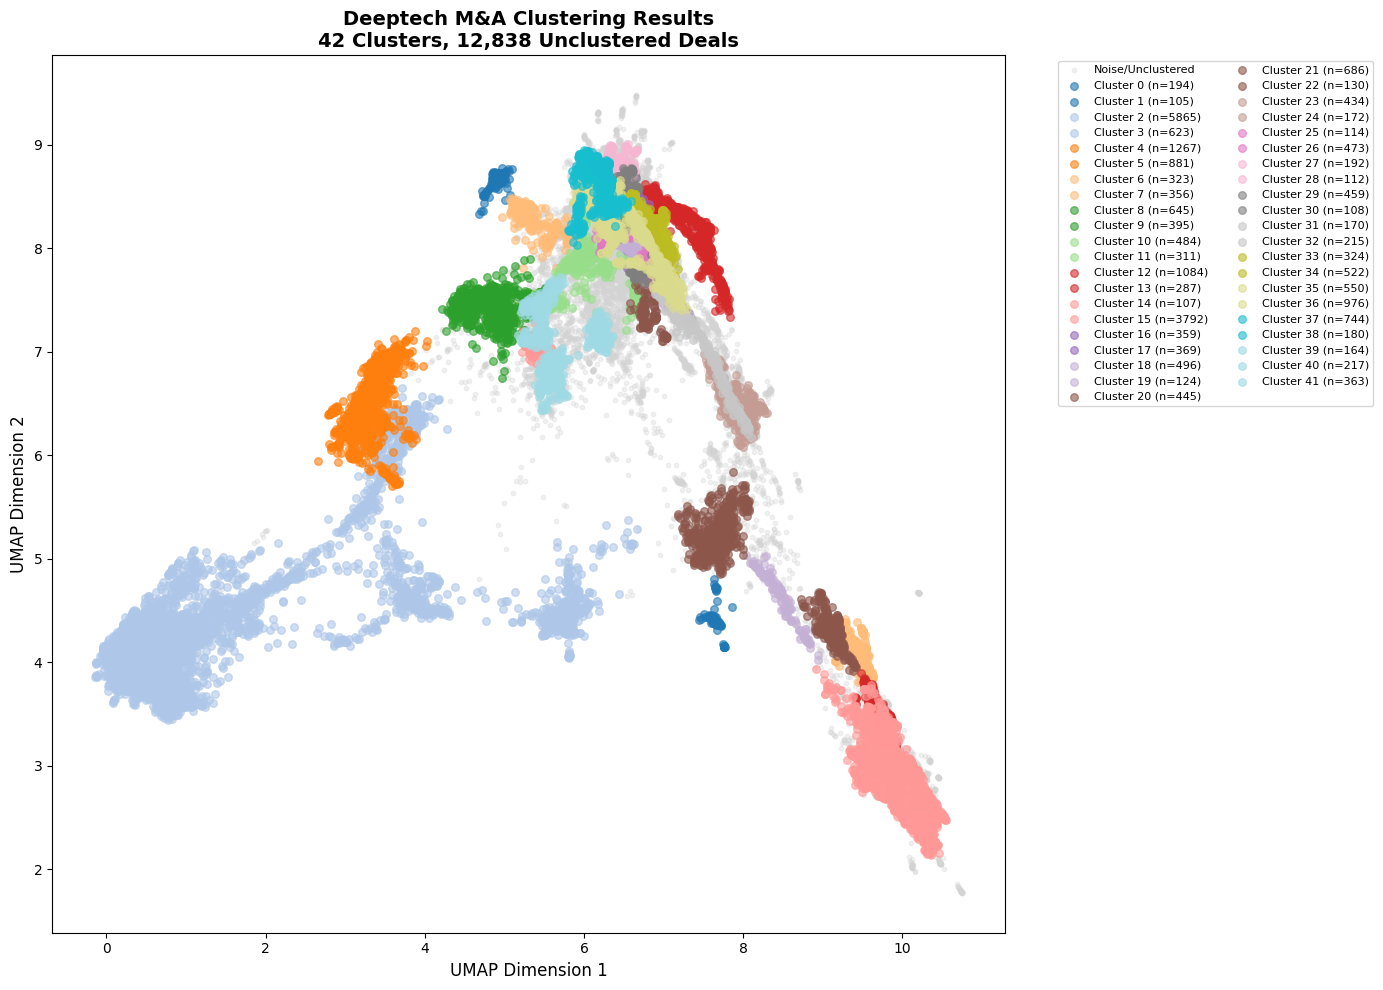


✓ Visualization complete.


In [11]:
import matplotlib.pyplot as plt

# Create a scatter plot of the UMAP-reduced embeddings colored by cluster
plt.figure(figsize=(14, 10))

# Get unique cluster labels (excluding noise)
unique_labels = df_valid_features.get_column("hdbscan_label").unique().sort()

# Create a color map
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot noise points (label -1) in gray
noise_mask = df_valid_features.get_column("hdbscan_label") == -1
if noise_mask.sum() > 0:
    plt.scatter(
        df_valid_features.filter(noise_mask).get_column("umap_x"),
        df_valid_features.filter(noise_mask).get_column("umap_y"),
        c='lightgray',
        alpha=0.3,
        s=10,
        label='Noise/Unclustered'
    )

# Plot each cluster
for idx, label in enumerate(unique_labels):
    if label == -1:
        continue
    
    cluster_mask = df_valid_features.get_column("hdbscan_label") == label
    cluster_data = df_valid_features.filter(cluster_mask)
    
    plt.scatter(
        cluster_data.get_column("umap_x"),
        cluster_data.get_column("umap_y"),
        c=[colors[idx]],
        alpha=0.6,
        s=30,
        label=f'Cluster {label} (n={len(cluster_data)})'
    )

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title(f'Deeptech M&A Clustering Results\n{num_clusters} Clusters, {noise_count:,} Unclustered Deals', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete.")

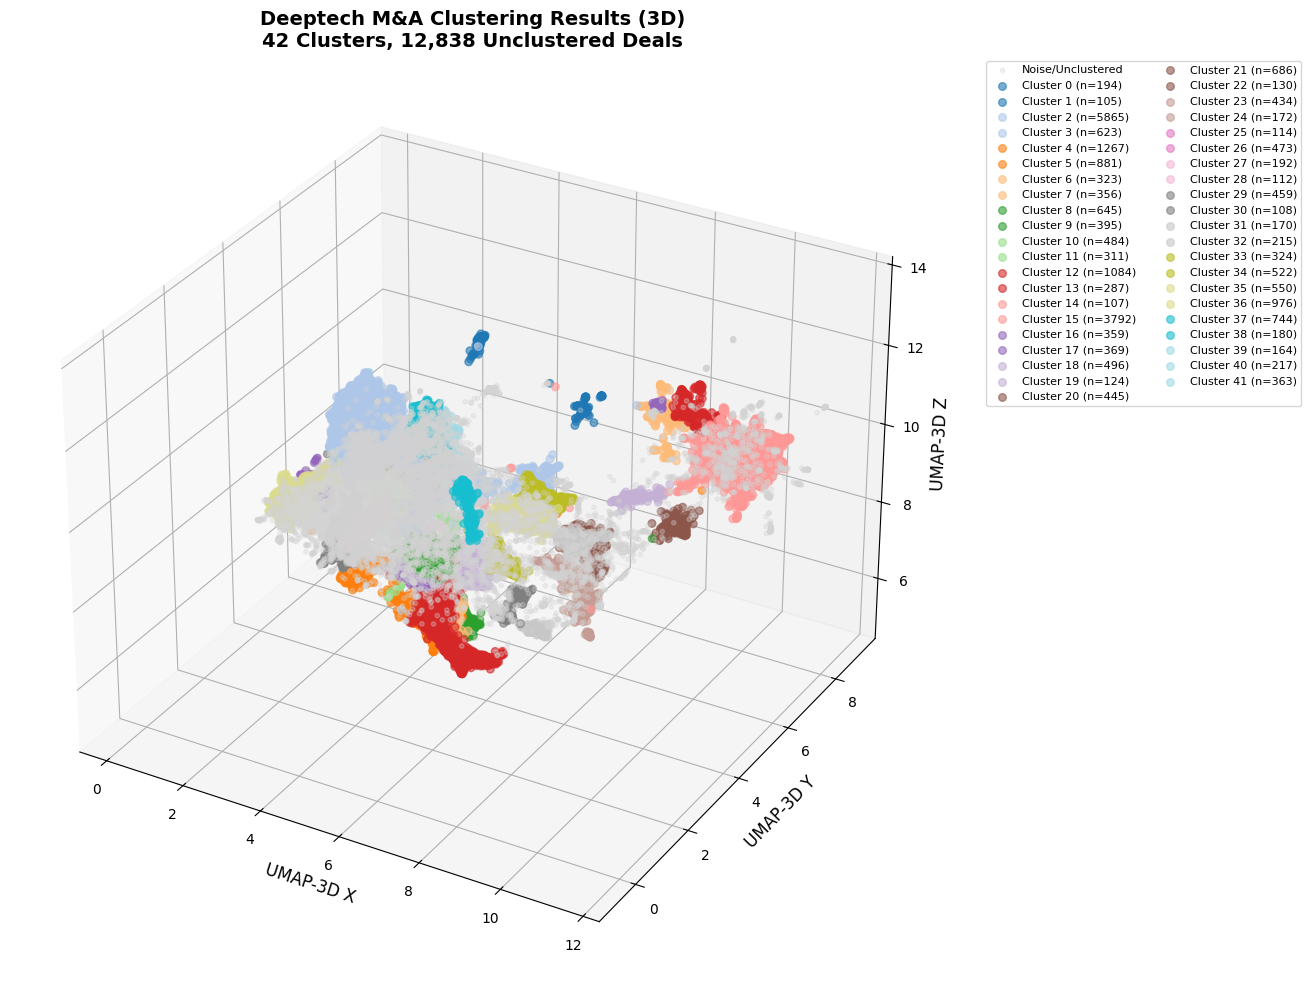


✓ 3D visualization complete.


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 3D scatter plot of the UMAP(3D)-reduced embeddings colored by cluster
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels (including noise)
unique_labels = df_valid_features.get_column("hdbscan_label").unique().sort()

# Create a color map
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot noise points (label -1) in gray
noise_mask = df_valid_features.get_column("hdbscan_label") == -1
if noise_mask.sum() > 0:
    noise = df_valid_features.filter(noise_mask)
    ax.scatter(
        noise.get_column("umap3d_x"),
        noise.get_column("umap3d_y"),
        noise.get_column("umap3d_z"),
        c='lightgray',
        alpha=0.3,
        s=10,
        label='Noise/Unclustered'
    )

# Plot each cluster
for idx, label in enumerate(unique_labels):
    if label == -1:
        continue
    
    cluster_mask = df_valid_features.get_column("hdbscan_label") == label
    cluster_data = df_valid_features.filter(cluster_mask)
    
    ax.scatter(
        cluster_data.get_column("umap3d_x"),
        cluster_data.get_column("umap3d_y"),
        cluster_data.get_column("umap3d_z"),
        c=[colors[idx]],
        alpha=0.6,
        s=30,
        label=f'Cluster {label} (n={len(cluster_data)})'
    )

ax.set_xlabel('UMAP-3D X', fontsize=12)
ax.set_ylabel('UMAP-3D Y', fontsize=12)
ax.set_zlabel('UMAP-3D Z', fontsize=12)
ax.set_title(f'Deeptech M&A Clustering Results (3D)\n{num_clusters} Clusters, {noise_count:,} Unclustered Deals', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

print(f"\n✓ 3D visualization complete.")

In [ ]:
import plotly.express as px

# Ensure 3D UMAP coordinates exist (compute if missing)
required_cols = {"umap3d_x", "umap3d_y", "umap3d_z", "hdbscan_label"}
if not required_cols.issubset(set(df_valid_features.columns)):
    print("3D coordinates missing; computing UMAP(3D) now…")
    umap_reducer_3d = umap.UMAP(
        n_components=3,
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric="cosine",
    )
    X_umap3d = umap_reducer_3d.fit_transform(X_scaled)
    df_valid_features = df_valid_features.with_columns([
        pl.Series(name="umap3d_x", values=X_umap3d[:, 0]),
        pl.Series(name="umap3d_y", values=X_umap3d[:, 1]),
        pl.Series(name="umap3d_z", values=X_umap3d[:, 2]),
    ])

# Prepare a DataFrame for Plotly
cols = ["umap3d_x", "umap3d_y", "umap3d_z", "hdbscan_label"]
if "embedding_text" in df_valid_features.columns:
    cols.append("embedding_text")
plot_df = df_valid_features.select(cols).to_pandas()

# Build a discrete color map with noise (-1) in grey
unique_labels = (
    df_valid_features.get_column("hdbscan_label").unique().sort().to_list()
)
palette = px.colors.qualitative.Dark24
color_map = {}
for i, lab in enumerate(unique_labels):
    if lab == -1:
        color_map[str(lab)] = "lightgray"
    else:
        color_map[str(lab)] = palette[i % len(palette)]

# Convert label to string for categorical coloring
plot_df["hdbscan_label_str"] = plot_df["hdbscan_label"].astype(str)

hover_cols = [c for c in ["embedding_text"] if c in plot_df.columns]
fig = px.scatter_3d(
    plot_df,
    x="umap3d_x",
    y="umap3d_y",
    z="umap3d_z",
    color="hdbscan_label_str",
    color_discrete_map=color_map,
    opacity=0.75,
    hover_data=hover_cols,
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(
    title=f"Deeptech M&A Clustering Results (3D Interactive)<br>{num_clusters} Clusters, {noise_count:,} Unclustered Deals",
    legend_title_text="Cluster",
    scene=dict(
        xaxis_title="UMAP-3D X",
        yaxis_title="UMAP-3D Y",
        zaxis_title="UMAP-3D Z",
    ),
    margin=dict(l=0, r=0, t=60, b=0),
)

fig.show()

print("\n✓ 3D interactive visualization complete.")